In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow import keras 

# Run in anaconda prompt first:
# conda install -c conda-forge librosa
import librosa
import librosa.display

In [8]:
# Make sure you have the following files in the same directory as this ipynb:
# 1. nsynth-test.tfrecord
# 2. nsynth-train.tfrecord
# 3. nsynth-valid.tfrecord

nsynth_test = tf.data.TFRecordDataset(['nsynth-test.tfrecord'])

In [9]:
def get_features(record):
    # We're only going to use a few features for now
    features = {
        # identifier string, this will be our label
        "note_str": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        # MIDI tuning standard value for pitch
        "pitch": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        # list of normalized audio 'samples' to represent the sound wave
        "audio": tf.io.FixedLenFeature(shape=[64000], dtype=tf.float32)
    }
    sample = tf.io.parse_single_example(record, features)
    
    return sample

In [10]:
test_ds = list(nsynth_test.map(get_features))

NotFoundError: nsynth-test.tfrecord; No such file or directory

In [11]:
# Note about how our audio feature is structured:
#
# 4 seconds * 14000 samples per second = 64000 samples
# We only have one channel (these sound clips are mono)
# Dynamic range of 16-bit PCM WAV (-2^15, 2^15 - 1) normalized to (-1, 1)


# We get the first sample in our test dataset as an example
clip1 = test_ds[0]['audio']

NameError: name 'test_ds' is not defined

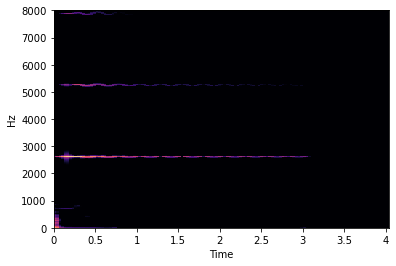

In [6]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(np.array(clip1))), ref=np.max)
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=16000)

In [7]:
# temporarily borrowing code just for demonstration purposes

def midi_pitch_to_frequency(d):
    return (2**((d-69)/12.0))*440.0

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

f = midi_pitch_to_frequency(100)
print("Frequency: ", f)
print("Note: ", pitch(f))

Frequency:  2637.02045530296
Note:  E7


In [8]:
test_ds[0]['pitch']
# We can observe a few things from the previous 3 results:

# 1. Our first audio clip has midi pitch value 100, which encodes the note E7. 
# 2. The note E7 has the fundamental frequency 2637.
# 3. The spectogram above has frequency ~2700 most represented.

<tf.Tensor: shape=(), dtype=int64, numpy=100>